In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from physlite_experiments.physlite_events import physlite_events, get_branch_forms, get_lazy_form
from physlite_experiments.analysis_example import *

In [2]:
%%time
filename = "/home/nikolai/data/user.elmsheus.21230205.EXT0._000002.DAOD_PHYSLITE.mc.pool.root"
#filename = "root://lcg-lrz-rootd.grid.lrz.de:1094/pnfs/lrz-muenchen.de/data/atlas/dq2/atlaslocalgroupdisk/rucio/data17_13TeV/16/cb/DAOD_PHYSLITE.22958312._001037.pool.root.1"
tree = uproot.open(f"{filename}:CollectionTree")

CPU times: user 1.08 s, sys: 13.3 ms, total: 1.09 s
Wall time: 1.09 s


In [3]:
%%time
events = physlite_events(tree, verbose=True)

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

In [4]:
%%time
evt_ak = get_obj_sel(events)

Loading part0-PrimaryVerticesAuxDyn.trackParticleLinks%offsets-offsets
Cache miss for  PrimaryVerticesAuxDyn.trackParticleLinks
Loading part0-AnalysisElectronsAuxDyn.trackParticleLinks%offsets-offsets
Cache miss for  AnalysisElectronsAuxDyn.trackParticleLinks
Loading part0-AnalysisElectronsAuxDyn.DFCommonElectronsLHLooseBL%content-data
Cache miss for  AnalysisElectronsAuxDyn.DFCommonElectronsLHLooseBL
Loading part0-AnalysisElectronsAuxDyn.pt%content-data
Cache miss for  AnalysisElectronsAuxDyn.pt
Loading part0-AnalysisElectronsAuxDyn.eta%content-data
Cache miss for  AnalysisElectronsAuxDyn.eta
Loading part0-AnalysisElectronsAuxDyn.DFCommonElectronsLHTight%content-data
Cache miss for  AnalysisElectronsAuxDyn.DFCommonElectronsLHTight
Loading part0-AnalysisElectronsAuxDyn.topoetcone20%content-data
Cache miss for  AnalysisElectronsAuxDyn.topoetcone20
Loading part0-AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA_pt1000%content-data
Cache miss for  AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA

/home/nikolai/.conda/envs/physlite-experiments/lib/python3.8/site-packages/awkward/_connect/_numpy.py:154: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


Loading part0-AnalysisJetsAuxDyn.phi%content-data
Cache miss for  AnalysisJetsAuxDyn.phi
Loading part0-AnalysisMuonsAuxDyn.phi%content-data
Cache miss for  AnalysisMuonsAuxDyn.phi
Loading part0-AnalysisElectronsAuxDyn.phi%content-data
Cache miss for  AnalysisElectronsAuxDyn.phi
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%offsets-offsets
Cache miss for  AnalysisJetsAuxDyn.GhostTrack
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%m_persKey%content-data
Loading part0-AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persKey%content-data
Cache miss for  AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persKey
Loading part0-AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persIndex%content-data
Cache miss for  AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persIndex
Loading part0-AnalysisJetsAuxDyn.GhostTrack%content%m_persIndex%content-data
CPU times: user 3.75 s, sys: 1.02 s, total: 4.77 s
Wall time: 3.78 s


In [5]:
from physlite_experiments.physlite_events import Factory, get_lazy_form, LazyGet

In [6]:
import json

In [7]:
form = json.dumps(get_lazy_form(get_branch_forms(tree)))

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

In [8]:
container = LazyGet(tree, verbose=True)

In [9]:
factory = Factory(form, tree.num_entries, container)

In [10]:
import timeit

In [11]:
def benchmark():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)

In [12]:
times = timeit.Timer(benchmark).repeat(number=1, repeat=5)

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

In [13]:
times, min(times)

([4.918366590000005,
  4.519695941999089,
  4.490460188000725,
  4.525938627999494,
  4.471803271999306],
 4.471803271999306)

In [14]:
import time

In [15]:
def run_benchmark_no_overhead():
    times = []
    for i in range(5):
        tree = uproot.open(f"{filename}:CollectionTree")
        events = physlite_events(tree)
        start = time.time()
        get_obj_sel(events)
        duration = time.time() - start
        times.append(duration)
    return times, min(times)

In [16]:
run_benchmark_no_overhead()

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

([3.2592570781707764,
  3.2801873683929443,
  3.264542579650879,
  3.281668186187744,
  3.302091121673584],
 3.2592570781707764)

In [17]:
def run_benchmark_obj_sel():
    tree = uproot.open(f"{filename}:CollectionTree")
    events = physlite_events(tree)
    get_obj_sel(events)
    times = timeit.Timer(lambda: get_obj_sel(events)).repeat(number=1, repeat=5)
    return times, min(times)

In [18]:
run_benchmark_obj_sel()

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

([1.756319471000097,
  1.8188769209991733,
  1.7857169270009763,
  1.740459976999773,
  1.6319377969994093],
 1.6319377969994093)

In [19]:
loaded_keys = list(factory.container.cache.keys())

In [20]:
from physlite_experiments.deserialization_hacks import tree_arrays

In [21]:
def run_benchmark_preload():
    tree = uproot.open(f"{filename}:CollectionTree")
    cache = tree_arrays(tree, lambda branch: branch.name in loaded_keys)
    container = LazyGet(tree, verbose=False, cache=cache)
    form = json.dumps(get_lazy_form(get_branch_forms(tree)))
    return timeit.Timer(
        lambda: get_obj_sel(Factory(form, tree.num_entries, container).events)
    ).repeat(number=1, repeat=5)

In [22]:
run_benchmark_preload()

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Skipping EventInfoAuxDyn.subEventTime
Skipping EventInfoAuxDyn.subEventIndex
Skipping EventInfoAuxDyn.subEventLink
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persKey
Skipping EventInfoAuxDyn.subEventLink/EventInfoAuxDyn.subEventLink.m_persIndex
Skipping EventInfoAuxDyn.subEventType
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I

[3.332097241000156,
 1.9827551460002724,
 1.7995813389989053,
 1.7420750800010865,
 1.7447720580003079]

In [23]:
# produced with athena + ST
# using https://gitlab.cern.ch/nihartma/enaf
def get_st_ntuple():
    f = uproot.open("/home/nikolai/code/enaf/run/ST_ntuple.root")
    tree = f["analysis"]
    keys = [k for k in tree.keys()]
    evt = ak.zip(
        {
            part[0].upper() + part[1:] + "s" : ak.zip(
                {k.split("_")[1] : tree[k].array() for k in keys if part in k}
            )
            for part in ["jet", "electron", "muon"]
        },
        depth_limit=1
    )
    # convert to bools
    bools = ["passOR", "passJvt", "baseline", "signal", "bad"]
    for part in evt.fields:
        for var in evt[part].fields:
            if var in bools:
                evt[part, var] = evt[part, var] == 1
    return evt

In [24]:
evt_st = get_st_ntuple()

In [25]:
df = []
for obj in ["Electrons", "Muons", "Jets"]:
    flags = ["all", "baseline", "passOR", "signal"]
    #if obj == "Jets":
    #    flags += ["passJvt"]
    for flag in flags:
        counts = []
        for e in [evt_ak, evt_st]:
            if flag != "all":
                counts.append(ak.count_nonzero(e[obj, flag]))
            else:
                counts.append(ak.sum(ak.num(e[obj])))
        entry = {
            "object" : obj,
            "flag" : flag,
            "athena/SUSYTools" : counts[1],
            "columnar analysis" : counts[0]
        }
        df.append(entry)
df = pd.DataFrame(df)

In [26]:
df.set_index(["object", "flag"])

athena/SUSYTools  columnar analysis
object    flag                                         
Electrons all                  23081              23081
          baseline             19219              19211
          passOR               18907              18898
          signal               14457              14623
Muons     all                  26475              26475
          baseline             22826              22914
          passOR               19455              19203
          signal               17453              17938
Jets      all                 524205             524205
          baseline            318948             318948
          passOR              296403             296414
          signal              298842             299005

In [27]:
df.set_index(["object", "flag"]).loc["Muons", "passOR"]

athena/SUSYTools     19455
columnar analysis    19203
Name: (Muons, passOR), dtype: int64

In [28]:
df.set_index(["object", "flag"]).loc["Jets", "passOR"]

athena/SUSYTools     296403
columnar analysis    296414
Name: (Jets, passOR), dtype: int64

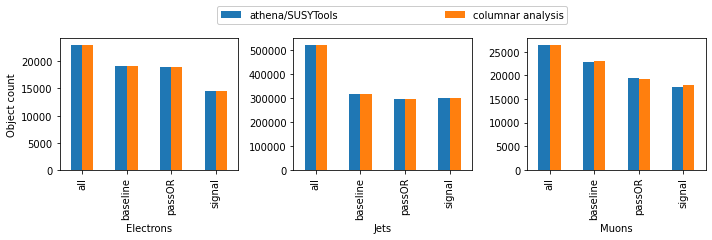

In [29]:
gb = df.groupby("object")
fig, axs = plt.subplots(figsize=(10, 3), ncols=len(gb), nrows=1)
for ax, group in zip(axs.ravel(), gb):
    group[1].pop("object")
    group[1].set_index("flag").plot(kind="bar", ax=ax, legend=False)
    ax.set_xlabel(group[0])
    if ax is axs[0]:
        ax.set_ylabel("Object count")
legend = fig.legend(
    *ax.get_legend_handles_labels(),
    framealpha=1,
    ncol=2,
    bbox_to_anchor=(0.3, 1.02, 0.5, .102),
    mode="expand",
)
fig.tight_layout()
fig.savefig("object_count_columnar_vs_st.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')

Loading part0-PrimaryVerticesAuxDyn.z%content-data
Cache miss for  PrimaryVerticesAuxDyn.z
Loading part0-CombinedMuonTrackParticlesAuxDyn.z0%content-data
Cache miss for  CombinedMuonTrackParticlesAuxDyn.z0


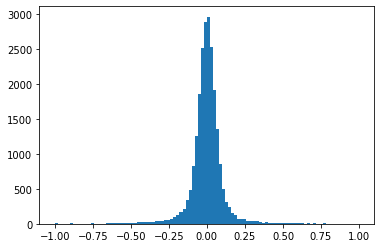

In [30]:
plt.hist(
    ak.flatten(ak.singletons(
        evt_ak.Muons[evt_ak.Muons.baseline].trackParticle.z0 - ak.firsts(evt_ak.PrimaryVertices.z)
    ), axis=None),
    bins=100, range=(-1, 1)
);

In [31]:
def overlay(selection, ax=None, **kwargs):
    ax = ax or plt.gca()
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_ak))), **kwargs)
    ax.hist(ak.to_numpy(ak.flatten(selection(evt_st))), **kwargs)
    return ax

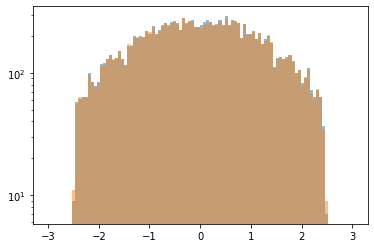

In [32]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

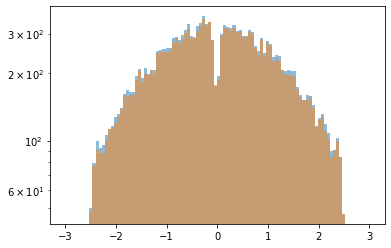

In [33]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

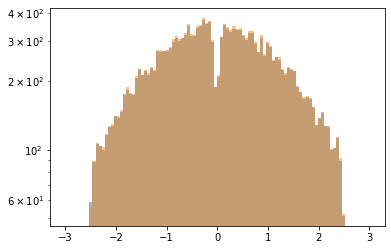

In [34]:
ax = overlay(lambda evt: evt.Muons[evt.Muons.passOR].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")

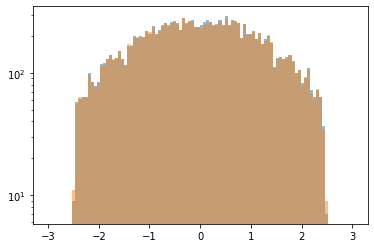

In [35]:
ax = overlay(lambda evt: evt.Electrons[evt.Electrons.signal].eta, bins=100, range=(-3, 3), alpha=0.5)
ax.set_yscale("log")